# Eesti Energia energiakaubanduse analüütiku konkursi tesülesande lahendus.
### Autor: Kertu Jõgi

1. Vaatle ühe aasta kohta tuule- ja päikesetoodangu andmeid. 
Milliseid sesoonsusi leiad? Näita neid kas graafiliselt või tabeli kujul.

2. Kas päevakeskmine tuule- ja päikesetoodang kumbki vastavad normaaljaotusele? 
Leia andmete põhjal tuule P90 näitaja (vihje: kogus, mida toodetakse vähemalt 90% kordadel)

3. Analüüsi tuule- ja päikesetoodangu mõju Eesti elektrihinnale, kasutades lineaarregressiooni 
ja tekkinud hüpoteesides veendumiseks statistilisi teste. 
Kas kumbki (või nende kombinatsioon) on hea näitaja elektrihinna ennustamiseks?

4. Arvuta välja tuule- ja päikesetoodanguga teenitud tulu (kogus x hind) 2021-2022 perioodi peale kokku. 
Leia selle kaudu iga kuu kaupa kogusega kaalutud keskmine hind. Seleta, mida see tähendab.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import normaltest
import numpy as np
import statsmodels.api as sm
from scipy import stats
from scipy.stats import norm

In [2]:
#Loena exceli faili sisse
data = pd.read_excel(
    'Praktika_kodutöö_2023_saatmisele.xlsx')
# asendan puuduvad väärtused keskmisega
data = data.fillna(data.mean())

In [3]:
data

,yr,mth,day,time,EE solar (MWh),EE tuul (MWh),EE spot hind (EUR/MWh)
0,2021,1,1,0,0.0,29.0,24.95
1,2021,1,1,1,0.0,29.0,24.35
2,2021,1,1,2,0.0,25.0,23.98
3,2021,1,1,3,0.0,20.0,23.72
4,2021,1,1,4,0.0,23.0,23.73
...,...,...,...,...,...,...,...
17513,2022,12,31,19,0.0,222.0,15.08
17514,2022,12,31,20,0.0,221.0,11.57
17515,2022,12,31,21,0.0,219.0,14.89
17516,2022,12,31,22,0.0,220.0,9.94


In [4]:
#Puhastan andmeid nii, et jääks ainult ühe aasta (2021) andmed.
df_2021 = data[data['yr'] == 2021]
df_2021

,yr,mth,day,time,EE solar (MWh),EE tuul (MWh),EE spot hind (EUR/MWh)
0,2021,1,1,0,0.0,29.0,24.95
1,2021,1,1,1,0.0,29.0,24.35
2,2021,1,1,2,0.0,25.0,23.98
3,2021,1,1,3,0.0,20.0,23.72
4,2021,1,1,4,0.0,23.0,23.73
...,...,...,...,...,...,...,...
8754,2021,12,31,19,0.0,15.0,92.66
8755,2021,12,31,20,0.0,22.0,92.00
8756,2021,12,31,21,0.0,27.0,78.03
8757,2021,12,31,22,0.0,21.0,69.70


### 1. ülesanne
Vaatle ühe aasta kohta tuule- ja päikesetoodangu andmeid. 
Milliseid sesoonsusi leiad? Näita neid kas graafiliselt või tabeli kujul.

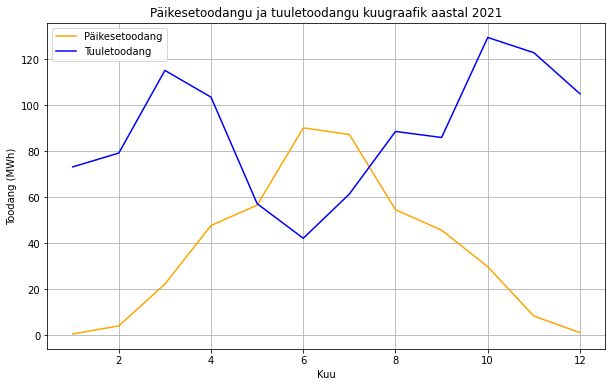

In [5]:
#Grupeerin kuude järgi ja leian kuude keskmised andmed
df_2021_kuu = df_2021.groupby('mth').mean()
# Teen kuudest sõltuva tuule- ja päikesetoodangu graafiku
plt.figure(figsize=(10,6))
plt.plot(df_2021_kuu.index, df_2021_kuu['EE solar (MWh)'], label='Päikesetoodang', color='orange')
plt.plot(df_2021_kuu.index, df_2021_kuu['EE tuul (MWh)'], label='Tuuletoodang', color='blue')

plt.xlabel('Kuu')
plt.ylabel('Toodang (MWh)')
plt.title('Päikesetoodangu ja tuuletoodangu kuugraafik aastal 2021')
plt.grid(True)
plt.legend()
plt.show()



/var/folders/wm/my711qhn59b2hcngjzgfwhq00000gn/T/ipykernel_22299/4269732603.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2021['aastaajad'] = df_2021['mth'].apply(lambda x: aastaajad[x])


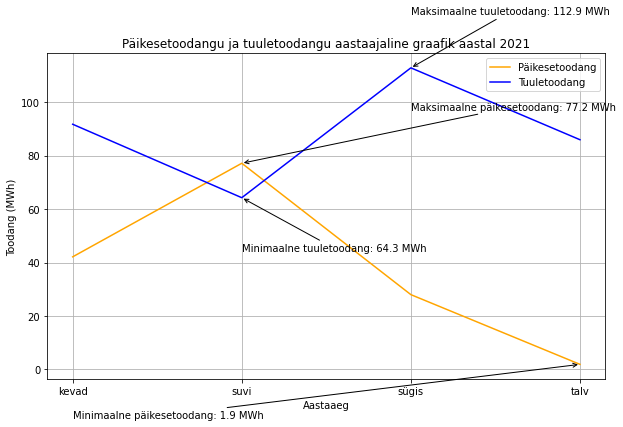

In [6]:
# Loon samade andmetega graafiku, kuid vaatlen paikese- ja tuuletoodangut sõltuvalt aastaegadest.
# detsember, jaanuar, veebruar => talv; märts, aprill, mai => kevad; juuni, juuli, august => suvi; september, oktoober, november => sügis.
# Lisan uue tulba aastaaegade jaoks
aastaajad = {12:'talv', 1:'talv', 2:'talv', 3:'kevad', 4:'kevad', 5:'kevad', 6:'suvi', 7:'suvi', 8:'suvi', 9:'sügis', 10:'sügis', 11:'sügis'}
df_2021['aastaajad'] = df_2021['mth'].apply(lambda x: aastaajad[x])

# Grupime andmed aastaaegade järgi ja arvutame keskmise väärtuse
df_2021_aastaajaliselt = df_2021.groupby('aastaajad').mean()

# Leian maksimaalsed ja minimaalsed väärtused, et need punktid graafikul ära märkida.
max_solar = df_2021_aastaajaliselt['EE solar (MWh)'].max()
min_solar = df_2021_aastaajaliselt['EE solar (MWh)'].min()
max_wind = df_2021_aastaajaliselt['EE tuul (MWh)'].max()
min_wind = df_2021_aastaajaliselt['EE tuul (MWh)'].min()


plt.figure(figsize=(10,6))
plt.plot(df_2021_aastaajaliselt.index, df_2021_aastaajaliselt['EE solar (MWh)'], label='Päikesetoodang', color='orange')
plt.plot(df_2021_aastaajaliselt.index, df_2021_aastaajaliselt['EE tuul (MWh)'], label='Tuuletoodang', color='blue')


# Lisan max/min väärtuste punktid graafikule
plt.annotate(f'Maksimaalne päikesetoodang: {max_solar:.1f} MWh', xy=('suvi', max_solar), xytext=('sügis', max_solar+20), arrowprops=dict(facecolor='black', arrowstyle="->"))
plt.annotate(f'Minimaalne päikesetoodang: {min_solar:.1f} MWh', xy=('talv', min_solar), xytext=('kevad', min_solar-20), arrowprops=dict(facecolor='black', arrowstyle="->"))
plt.annotate(f'Maksimaalne tuuletoodang: {max_wind:.1f} MWh', xy=('sügis', max_wind), xytext=('sügis', max_wind+20), arrowprops=dict(facecolor='black', arrowstyle="->"))
plt.annotate(f'Minimaalne tuuletoodang: {min_wind:.1f} MWh', xy=('suvi', min_wind), xytext=('suvi', min_wind-20), arrowprops=dict(facecolor='black', arrowstyle="->"))

plt.xlabel('Aastaaeg')
plt.ylabel('Toodang (MWh)')
plt.title('Päikesetoodangu ja tuuletoodangu aastaajaline graafik aastal 2021')

plt.grid(True)
plt.legend()
plt.show()

**VASTUS**:

Teise graafiku ('Päikesetoodangu ja tuuletoodangu aastaajaline graafik aastal 2021') pealt on näha, et keskmiselt päikesetoodang on kõige suurem suvekuudel. Vaadates esimest graafikut ('Päikesetoodangu ja tuuletoodangu kuugraafik aastal 2021') näeme, et kõige suurem päikesetoodang oli juunikuus (keskmiselt 77.2 MWh). Päikesetoodang on kõige madalam aga talvekuudel, kusjuures minimaalne päikesetoodang oli jaanuarikuus (keskmiselt 1,9 MWh).
Tuuletoodang oli aga kõige suurem sügiskuudel, kus maksimum toodang oli oktoobris keksmiselt 112,9 MWh. Kõige väiksem tuuletoodang, vastupidiselt päikesetoodangule, oli aga suvekuudel. Minimaalselt juunikuus keksmiselt 64,3 MWh.

### 2. ülesanne
Kas päevakeskmine tuule- ja päikesetoodang kumbki vastavad normaaljaotusele? 
Leia andmete põhjal tuule P90 näitaja (vihje: kogus, mida toodetakse vähemalt 90% kordadel)

In [7]:
# Loen andmed sisse pandas dataframe'i
df = data

In [8]:
tuul_keksmine = df.groupby(['yr', 'mth', 'day'])['EE tuul (MWh)'].mean()
päike_keksmine = df.groupby(['yr', 'mth', 'day'])['EE solar (MWh)'].mean()


df_pk=pd.DataFrame()
df_pk['tuul_keksmine']=tuul_keksmine
df_pk['päike_keksmine']=päike_keksmine


tuul_mean = df_pk.describe()['tuul_keksmine']['mean']
päike_mean = df_pk.describe()['päike_keksmine']['mean']
tuul_std = df_pk.describe()['tuul_keksmine']['std']
päike_std = df_pk.describe()['päike_keksmine']['std']

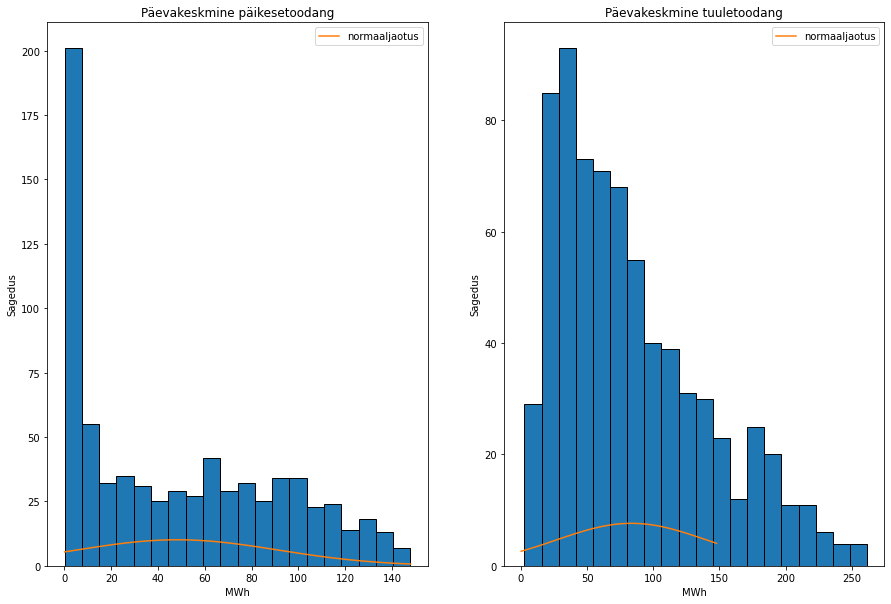

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 10))

# päevakeskmise päikesetoodangu histogramm
ax1.hist(df_pk['päike_keksmine'], bins=20, edgecolor='black')
ax1.set_title('Päevakeskmine päikesetoodang')
ax1.set_xlabel('MWh')
ax1.set_ylabel('Sagedus')

# päevakeskmise tuuletoodangu histogrammi
ax2.hist(df_pk['tuul_keksmine'], bins=20, edgecolor='black')
ax2.set_title('Päevakeskmine tuuletoodang')
ax2.set_xlabel('MWh')
ax2.set_ylabel('Sagedus')

x = np.linspace(df_pk['päike_keksmine'].min(), df_pk['päike_keksmine'].max(), 100)
ax1.plot(x, len(df_pk['päike_keksmine']) * np.diff(x)[0] * norm.pdf(x, loc=päike_mean, scale=päike_std), label='normaaljaotus')
ax2.plot(x, len(df_pk['tuul_keksmine']) * np.diff(x)[0] * norm.pdf(x, loc=tuul_mean, scale=tuul_std), label='normaaljaotus')

# lisa legend histogrammile ja normaaljaotusele
ax1.legend()
ax2.legend()

# näita plot
plt.show()

In [10]:
#Kui vaadelda tuule- ja päikesetoodangut koos
päeva_keskmine = df.groupby(['yr', 'mth', 'day'])[['EE solar (MWh)', 'EE tuul (MWh)']].mean()
päeva_keskmine['päeva_keskmine'] = päeva_keskmine.mean(axis=1)

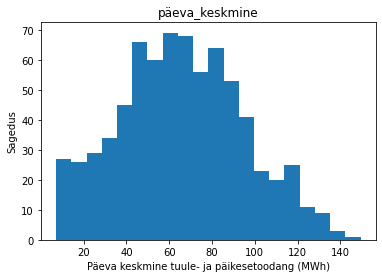

In [11]:
mean = päeva_keskmine.mean()
std = päeva_keskmine.std()

päeva_keskmine.hist(column='päeva_keskmine', bins=20, grid=False)

plt.xlabel('Päeva keskmine tuule- ja päikesetoodang (MWh)')
plt.ylabel('Sagedus')
plt.show()

In [12]:
# Leiame tuule P90 näitaja

P90 = df["EE tuul (MWh)"].quantile(0.1)

print("Tuule P90 näitaja: %.2f MWh" % P90)

Tuule P90 näitaja: 16.00 MWh


**VASTUS:**

Päevakeskmine tuule- ja päikesetoodang kumbki eraldi ei vasta normaaljaotusele. Kui vaadelda tuule- ja päikesetoodangut koos, siis saab väita, et see vastab normaaljaotusele.
Tuule P90 näitaja ehk kogus, mida toodetakse vähemalt 90% kordadel on 16.00 MWh.

### Ülesanne 3:

Analüüsi tuule- ja päikesetoodangu mõju Eesti elektrihinnale, kasutades lineaarregressiooni ja tekkinud hüpoteesides veendumiseks statistilisi teste. 
Kas kumbki (või nende kombinatsioon) on hea näitaja elektrihinna ennustamiseks?

In [13]:
df3 = data
df3

,yr,mth,day,time,EE solar (MWh),EE tuul (MWh),EE spot hind (EUR/MWh)
0,2021,1,1,0,0.0,29.0,24.95
1,2021,1,1,1,0.0,29.0,24.35
2,2021,1,1,2,0.0,25.0,23.98
3,2021,1,1,3,0.0,20.0,23.72
4,2021,1,1,4,0.0,23.0,23.73
...,...,...,...,...,...,...,...
17513,2022,12,31,19,0.0,222.0,15.08
17514,2022,12,31,20,0.0,221.0,11.57
17515,2022,12,31,21,0.0,219.0,14.89
17516,2022,12,31,22,0.0,220.0,9.94


In [14]:
#loon uue tulb "EE tuul ja päike (MWh)" tuule- ja päikesetoodangu summadega iga andmepunkti kohta. 
df3['EE tuul ja päike (MWh)'] = df3['EE solar (MWh)'] + df3['EE tuul (MWh)']
df3

,yr,mth,day,time,EE solar (MWh),EE tuul (MWh),EE spot hind (EUR/MWh),EE tuul ja päike (MWh)
0,2021,1,1,0,0.0,29.0,24.95,29.0
1,2021,1,1,1,0.0,29.0,24.35,29.0
2,2021,1,1,2,0.0,25.0,23.98,25.0
3,2021,1,1,3,0.0,20.0,23.72,20.0
4,2021,1,1,4,0.0,23.0,23.73,23.0
...,...,...,...,...,...,...,...,...
17513,2022,12,31,19,0.0,222.0,15.08,222.0
17514,2022,12,31,20,0.0,221.0,11.57,221.0
17515,2022,12,31,21,0.0,219.0,14.89,219.0
17516,2022,12,31,22,0.0,220.0,9.94,220.0


In [15]:
# Regressioonimudel, kus sõltuvaks muutujaks on "EE elektri hind (EUR/MWh)" ja sõltumatuks muutujaks on "EE tuul ja päike (MWh)".

# Valin väljundi ehk sõltumatu muutuja ja sisendmuutuja ehk sõltuva muutuja.
X = df3['EE tuul ja päike (MWh)']
y = df3['EE spot hind (EUR/MWh)']

# Lisan konstandi X-i.
X = sm.add_constant(X)

# Loon lineaarse regressioonimudeli.
model = sm.OLS(y, X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     EE spot hind (EUR/MWh)   R-squared:                       0.005
Model:                                OLS   Adj. R-squared:                  0.005
Method:                     Least Squares   F-statistic:                     81.90
Date:                    Sun, 02 Apr 2023   Prob (F-statistic):           1.57e-19
Time:                            19:01:17   Log-Likelihood:            -1.0864e+05
No. Observations:                   17518   AIC:                         2.173e+05
Df Residuals:                       17516   BIC:                         2.173e+05
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                    150.4415      1.484    101.382      0.000     147.533     153.350
EE tuul ja päike (MWh)    -0.0809      0.009     -9.050      0.000      -0.098      -0.063
==============================================================================
Omnibus:                    15570.583   Durbin-Watson:                   0.209
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          3172237.560
Skew:                           3.598   Prob(JB):                         0.00
Kurtosis:                      68.531   Cond. No.                         273.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Esimene osa vastuses**

Eelneva regressiooni mudeli pealt näeme, et EE tuul ja päike (MWh) koefitsent on negatiivne. See tähendab, et elektrihind langeb koos tuule- ja päikesetoodangu kasvuga. Samas mudeli R-ruudu väärtus on 0.005 ehk päikesetoodangu ja tuuletoodangu summa selgitab ainult 0,5% elektrihinna muutustest. See võib viidata sellele, et päikesetoodangu ja tuuletoodangu mõju Eesti elektrihinnale on väga väike. 


Koostan ka paremaks analüüsiks T-testi.

Esmalt määran hüpoteesid:
H0: tuule- ja päikesetoodangu ning elektrihinna vahel ei ole seost
H1: tuule- ja päikesetoodangu ning elektrihinna vahel on seos

Valin siin α = 0,05.

In [16]:
# Määrame sõltumatu muutuja
x = df3['EE tuul ja päike (MWh)']
# Määrame sõltuva muutuja
y = df3['EE spot hind (EUR/MWh)']

# Koostame t-testi
t_stat, p_value = stats.ttest_ind(x, y)

# Väljastame tulemused
print(f"T-tulemus: {t_stat:.4f}")
print(f"p-väärtus: {p_value:.4f}")

T-tulemus: -6.7819
p-väärtus: 0.0000


**Teine osa vastuses**


Eelnevalt näeme, et p-väärtus < α. Ehk lükkan tagasi nullhüpoteesi (H0) ja väidan, et tuule- ja päikesetoodangu ning elektrihinna vahel on seos. Seda seost nägime ka regressioonimudeli pealt (elektrihind langeb kui tuule- ja päikesetoodang kasvab). Samas regressioonimudeli pealt võisime eeldada, et tuule- ja päikesetoodang ei ole antud andmete ajaraamistikus  suurim hinna muutust põhjustav tegur.


Seega eelneva põhjal saab väita, et kombinatsioon regressioonimudeli ning statistilistest testidest annab hea ülevaate elektrihinna ennustamiseks. Samas veelgi täpsemaks ennustamiseks oleks vaja kaasata rohkem muutujaid, nagu näiteks energiatootmiseks kasutatavate kütuste hind, tarbimismustrid jne.


### Ülesanne 4:

Arvuta välja tuule- ja päikesetoodanguga teenitud tulu (kogus x hind) 2021-2022 perioodi peale kokku. 
Leia selle kaudu iga kuu kaupa kogusega kaalutud keskmine hind. Seleta, mida see tähendab.


In [17]:
df4 = data
df4

,yr,mth,day,time,EE solar (MWh),EE tuul (MWh),EE spot hind (EUR/MWh),EE tuul ja päike (MWh)
0,2021,1,1,0,0.0,29.0,24.95,29.0
1,2021,1,1,1,0.0,29.0,24.35,29.0
2,2021,1,1,2,0.0,25.0,23.98,25.0
3,2021,1,1,3,0.0,20.0,23.72,20.0
4,2021,1,1,4,0.0,23.0,23.73,23.0
...,...,...,...,...,...,...,...,...
17513,2022,12,31,19,0.0,222.0,15.08,222.0
17514,2022,12,31,20,0.0,221.0,11.57,221.0
17515,2022,12,31,21,0.0,219.0,14.89,219.0
17516,2022,12,31,22,0.0,220.0,9.94,220.0


In [18]:
df4_2021_2022 = data.loc[(df4['yr'] >= 2021) & (df4['yr'] <= 2022)]

In [19]:
# päikesetoodanguga ja tuuletoodanguga teenitud tulu perioodil 2021-2022
päikesetoodangu_tulu = (df4_2021_2022['EE solar (MWh)'] * df4_2021_2022['EE spot hind (EUR/MWh)']).sum()
tuuletoodangu_tulu = (df4_2021_2022['EE tuul (MWh)'] * df4_2021_2022['EE spot hind (EUR/MWh)']).sum()

print("Perioodil 2021-2022 päikesetoodanguga teenitud tulu: %.2f EUR" % päikesetoodangu_tulu)
print("Perioodil 2021-2022 tuuletoodanguga teenitud tulu: %.2f EUR" % tuuletoodangu_tulu)

Perioodil 2021-2022 päikesetoodanguga teenitud tulu: 132162558.35 EUR
Perioodil 2021-2022 tuuletoodanguga teenitud tulu: 176022185.13 EUR


In [20]:
# kokku tuule- ja päikesetoodanguga teenitud tulu 2021-2022 perioodil
kokku_tulu = päikesetoodangu_tulu + tuuletoodangu_tulu
print("Perioodil 2021-2022 päikesetoodanguga ja tuuletoodanguga  kokku teenitud tulu: %.2f EUR" % kokku_tulu)

Perioodil 2021-2022 päikesetoodanguga ja tuuletoodanguga  kokku teenitud tulu: 308184743.48 EUR


In [21]:
# lisan tulbad ['päikesetoodangu tulu', 'tuuletoodangu tulu']

df4['päikesetoodangu tulu']= df4['EE solar (MWh)']*df4['EE spot hind (EUR/MWh)']
df4['tuuletoodangu tulu']= df4['EE tuul (MWh)']*df4['EE spot hind (EUR/MWh)']

In [22]:
# Grupeerin andmed kuude kaupa ja leian igale kuule vastava kuu kaupa päikesetoodangu tulu ja tuuletoodangu tulu summa ning nende koguse kaalutud keskmise hinna
kuu_data = df4.groupby(['yr', 'mth']).agg(
    päikese_tulu=('päikesetoodangu tulu', 'sum'),
    tuule_tulu=('tuuletoodangu tulu', 'sum'),
    päikese_kogus=('EE solar (MWh)', 'sum'),
    tuule_kogus=('EE tuul (MWh)', 'sum'),
    kaalutud_keskmine=('EE spot hind (EUR/MWh)', lambda x: np.average(x, weights=data.loc[x.index, 'EE solar (MWh)']+data.loc[x.index, 'EE tuul (MWh)']))
)

kuu_data


päikese_tulu    tuule_tulu  päikese_kogus   tuule_kogus  \
yr   mth                                                            
2021 1    2.890864e+04  2.886730e+06          463.6  54433.000000   
     2    1.385838e+05  2.913773e+06         2778.9  53194.000000   
     3    8.679091e+05  3.472360e+06        16564.4  85482.476359   
     4    1.822386e+06  2.778161e+06        34353.4  74466.000000   
     5    2.138410e+06  2.039346e+06        42091.9  42543.000000   
     6    4.941663e+06  1.956812e+06        64870.9  30362.000000   
     7    5.814241e+06  3.733386e+06        64898.6  45666.000000   
     8    3.724656e+06  5.593985e+06        40584.6  65871.000000   
     9    4.085572e+06  7.489704e+06        32901.4  61864.905438   
     10   2.708640e+06  9.222760e+06        22189.5  96235.500000   
     11   7.134563e+05  1.044830e+07         6051.6  88376.000000   
     12   2.108381e+05  1.390697e+07          891.8  78045.000000   
2022 1    4.370223e+05  1.309157e+07         2567.4  96380.000000   
     2    1.329563e+06  8.448477e+06        10634.0  92635.952719   
     3    6.886999e+06  8.555306e+06        53321.0  63281.905438   
     4    6.749051e+06  5.316811e+06        63888.4  64003.287235   
     5    1.166100e+07  7.063189e+06        73705.5  48863.000000   
     6    1.386947e+07  5.179702e+06        79685.6  31460.905438   
     7    1.765537e+07  7.044647e+06        77461.1  30865.952719   
     8    2.642831e+07  1.200484e+07        74770.7  35279.381797   
     9    1.424021e+07  7.786420e+06        51364.6  35708.000000   
     10   4.589091e+06  1.179840e+07        23994.8  73536.929078   
     11   8.567014e+05  9.122508e+06         4329.9  49943.000000   
     12   2.645134e+05  1.416803e+07         1406.4  63841.669033   

          kaalutud_keskmine  
yr   mth                     
2021 1            53.111457  
     2            54.532756  
     3            42.532110  
     4            42.276897  
     5            49.362090  
     6            72.437935  
     7            86.353383  
     8            87.535475  
     9           122.145490  
     10          100.750686  
     11          118.204357  
     12          178.849565  
2022 1           136.725046  
     2            94.684264  
     3           132.434998  
     4            94.344385  
     5           152.765092  
     6           171.387918  
     7           228.013328  
     8           349.233280  
     9           252.968607  
     10          168.022123  
     11          183.870941  
     12          221.194974

**Mida tähendab kogusega kaalutud keskmine hind?**

Kogusega kaalutud keskmist hinda leitakse (selle ülesande puhul) järgnevalt: ((tuule- ja päikesetoodangu hinna summa) * tuule- ja päikesetoodangu kogus) / tuule- ja päikesetoodangu kogu koguste summa

Ülal arvutatud kogusega kaalutud keskmine hind arvutatati kaalutud keskmise hinna valemi abil, kus kaaluks on vastava rea päikesetoodangu ja tuuletoodangu summa (quantity) ning hinnaks on vastava rea päikesetoodangu ja tuuletoodangu summa (revenue) summa.

Tulemused väljastatakse DataFrame'ina, kus iga rea esindab ühte kuud ning  tulpadeks on kuuga seotud päikesetoodangu tulu, tuuletoodangu tulu, päikesetoodangu kogus, tuuletoodangu kogus ja koguse kaalutud keskmine hind.
